In [2]:
!pip install opencv-contrib-python==3.4.0.12 
# otherwise you'd get an error message saying this when you try to use SIFT
# This algorithm is patented and is excluded in this configuration; 
# Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in 
# function 'cv::xfeatures2d::SIFT::create'

In [5]:
from typing import List, Set, Dict, Tuple, Optional

import numpy as np
import pandas as pd

from scipy import ndimage, signal
from scipy.ndimage import gaussian_filter
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

import random
import math
import os

from copy import deepcopy

!pip install opencv-python
import cv2

import plotly.graph_objects as go

from google.colab.patches import cv2_imshow

In [6]:
def get_images(path0:str, path1:str) -> Tuple[np.ndarray, np.ndarray]:
  """
  Loads the images from the paths specified
  :param str path0: Path to the left image
  :param str path1: Path to the right image
  :returns: A pair of image matrices that represent the pixel intensities of the images
  :rtype: Tuple[np.ndarray, np.ndarray]
  """
  img0 = cv2.imread(path0, cv2.IMREAD_GRAYSCALE)
  img1 = cv2.imread(path1, cv2.IMREAD_GRAYSCALE)

  return img0, img1

In [4]:
def get_point_matches(img1:np.ndarray, img2:np.ndarray, metric:str='SIFT', 
                      threshold:float=0.5) -> Tuple[np.ndarray, np.ndarray]:
  """
  Determines feature points through a feature measure in both images and 
  matches them. Adapted from Assignment3.

  :param np.ndarray img1: The first image matrix
  :param np.ndarray img2: The second image matrix
  :param str metric: The feature matching measure to use {"SIFT", "SURF", "ORB"}
  :param float threshold: The threshold used for the ratio test
  :returns: A pair of arrays of matching points selected by the feature matching
    measure previously specified.
  :rtype: Tuple[np.ndarray, np.ndarray]
  """
  if metric == 'SIFT':
    descriptor = cv2.xfeatures2d.SIFT_create()
  elif metric == 'SURF':
    descriptor = cv2.xfeatures2d.SURF_create()
  else:
    descriptor = cv2.ORB_create(nfeatures=1000)
  
  kp1, desc1 = descriptor.detectAndCompute(img1, None)
  kp2, desc2 = descriptor.detectAndCompute(img2, None)

  bf = cv2.BFMatcher()
  matches = bf.knnMatch(desc1, desc2, k=2) # k=2 means find the top two matchs for each query descriptor

  # Apply ratio test (as per David Lowe's SIFT paper: compare the best match with the 2nd best match_
  good_matches = []
  good_matches_without_list = []
  for m,n in matches:
      if m.distance < threshold*n.distance: # only accept matchs that are considerably better than the 2nd best match
          good_matches.append([m])
          good_matches_without_list.append(m) # this is to simplify finding a homography later


  src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches_without_list ]).reshape(-1,2)
  dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches_without_list ]).reshape(-1,2)

  # filter out bad point matches with Least Median Squared
  method = cv2.LMEDS #{cv2.RANSAC or cv2.LMEDS}
  M, mask = cv2.findHomography(src_pts, dst_pts, method, 5)
  src_pts = src_pts[mask.ravel()==1]
  dst_pts = dst_pts[mask.ravel()==1]
  
  # sort point pairs by decreasing x values of the image1 matched points
  src_dst_pts = np.concatenate((src_pts, dst_pts), axis=1)
  src_dst_pts = src_dst_pts[np.argsort(src_dst_pts[:,0])]

  src_pts = src_dst_pts[:,0:2]
  dst_pts = src_dst_pts[:,2:]
  
  plt.figure()
  img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good_matches,
                          None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS, 
                          matchColor=(0,255,0))
  plt.figure(figsize = (10,10))
  plt.imshow(img3), plt.show()

  return src_pts, dst_pts

In [7]:
def extract_calibration_vals(filename:str, 
                             image_numbers:Tuple[int,int]
                             ) -> Dict[str, np.ndarray]:
  """
  Gets the camera parameters of the images from the given filename path.

  :param str filename: Filename of the camera parameters file
  :param Tuple[int,int] image_numbers: The indices (indexed by one) of the 
    images to compare.
  :returns: Camera intrinsic and extrinsic parameters for the relevant images 
    that are being compared
  :rtype: Dict[str, np.ndarray]
  """
  image1, image2 = image_numbers

  calib_vals = {}
  temple_par = pd.read_csv(filename, delimiter=' ', dtype=str, skiprows=[0], 
                           index_col=0, header=None)
  temple_par.columns = ['k11', 'k12', 'k13', 'k21', 'k22', 'k23', 
                        'k31', 'k32', 'k33', 'r11', 'r12', 'r13', 
                        'r21', 'r22', 'r23', 'r31', 'r32', 'r33', 
                        't1', 't2', 't3']
  temple_par.index.name = 'image name'
  K0 = temple_par.iloc[image1,0:9].values.reshape(3,3).astype(float)
  R0 = temple_par.iloc[image1,9:18].values.reshape(3,3).astype(float)
  t0 = temple_par.iloc[image1,18:].values.reshape(3,1).astype(float)
  K1 = temple_par.iloc[image2,0:9].values.reshape(3,3).astype(float)
  R1 = temple_par.iloc[image2,9:18].values.reshape(3,3).astype(float)
  t1 = temple_par.iloc[image2,18:].values.reshape(3,1).astype(float)
  calib_vals['cam0'] = K0
  calib_vals['cam1'] = K1
  calib_vals['R0'] = R0
  calib_vals['R1'] = R1
  calib_vals['t0'] = t0
  calib_vals['t1'] = t1
  calib_vals['baseline'] = np.linalg.norm(t1 - t0)
  return calib_vals

In [8]:
def drawlines(img1:np.ndarray, img2:np.ndarray, lines:np.ndarray, 
              pts1:np.ndarray, pts2:np.ndarray, colours:np.ndarray
              ) -> Tuple[np.ndarray, np.ndarray]:
  """
  Adapted from openCV epipolar geometry tutorial
  https://docs.opencv.org/master/da/de9/tutorial_py_epipolar_geometry.html

  Plots the epipolar lines and feature-mapped points for the left and right 
  images.

  :param np.ndarray img1: The Left image to compare
  :param np.ndarray img2: The Right image to compare
  :param np.ndarray lines: The epipolar lines to plot
  :param np.ndarray pts1: The feature points in the Left image to plot
  :param np.ndarray pts2: The feature points in the Right image to plot
  :param np.ndarray colours: A colour array to read from in order to make 
    matching points have the same colour.
  :returns: Left and Right images with their corresponding epipolar lines and 
    feature points plotted on top
  :rtype: Tuple[np.ndarray, np.ndarray]
  """

  r,c = img1.shape
  img1 = img1.transpose()
  img2 = img2.transpose()
  img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
  img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
  for index, (r, pt1, pt2) in enumerate(zip(lines, pts1, pts2)):
      colour = colours[index]
      x0,y0 = map(int, [0, -r[2]/r[1] ])
      x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
      img1 = cv2.line(img1, (y0,x0), (y1,x1), colour, 1)
      img1 = cv2.circle(img1, tuple(pt1)[::-1], 5, colour, -1)
      img2 = cv2.circle(img2, tuple(pt2)[::-1], 5, colour, -1)
  return img1, img2

In [9]:
def compute_epipolar_lines(F:np.ndarray, img1:np.ndarray, img2:np.ndarray, 
                           pts1:np.ndarray, pts2:np.ndarray, 
                           image_path_0:str, image_path_1:str):
  """
  Adapted from openCV epipolar geometry tutorial
  https://docs.opencv.org/master/da/de9/tutorial_py_epipolar_geometry.html

  Calculates the epipolar lines from a given fundamental matrix and plots them

  :param np.ndarray F: The fundamental matrix
  :param np.ndarray img1: The Left image
  :param np.ndarray img2: The Right image
  :param np.ndarray pts1: The matched feature points for the Left image
  :param np.ndarray pts2: The matched feature points for the Right image
  :param str image_path_0: The image path for the Left image (for plot title)
  :param str image_path_1: The image path for the Right image (for plot title)
  :returns: None
  """

  # Find epilines corresponding to points in right image (second image) and
  # drawing its lines on left image

  # Acquire colors:
  rainbow_cm = plt.get_cmap('rainbow')
  c_norm  = colors.Normalize(vmin=0, vmax=len(pts1)-1)
  scalar_map = cmx.ScalarMappable(norm=c_norm, cmap=rainbow_cm)
  
  colours = []
  for i in range(len(pts1)):
    colours.append(np.asarray(scalar_map.to_rgba(i)[:3])*255)

  lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
  lines1 = lines1.reshape(-1,3)
  img5,img6 = drawlines(img1, img2, lines1, pts1, pts2, colours)
  # Find epilines corresponding to points in left image (first image) and
  # drawing its lines on right image
  lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
  lines2 = lines2.reshape(-1,3)
  img3,img4 = drawlines(img2, img1, lines2, pts2, pts1, colours)

  fig, axs = plt.subplots(1, 2, figsize=(20, 10))
  axs[0].imshow(img5)
  axs[0].set_ylim(0, img1.shape[1])
  axs[0].set_title('Epipolar Lines of image {}'.format(image_path_0))
  axs[1].imshow(img3)
  axs[1].set_ylim(0, img1.shape[1])
  axs[1].set_title('Epipolar Lines of image {}'.format(image_path_1))
  
  plt.show()

In [11]:
def open_cv_homography(img0:np.ndarray, img1:np.ndarray, F:np.ndarray, 
                       img0_pts:np.ndarray, img1_pts:np.ndarray, 
                       suppress_images:bool
                       ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
  """ 
  Adapted from openCV epipolar geometry tutorial
  https://docs.opencv.org/master/da/de9/tutorial_py_epipolar_geometry.html

  Calculates the homography matrices used to rectify the left and right images 
  based on the given fundamental matrix and a set of matched feature points.
  
  :param np.ndarray img1: The Left image
  :param np.ndarray img2: The Right image
  :param np.ndarray F: The fundamental matrix
  :param np.ndarray img0_pts: The matched feature points for the Left image
  :param np.ndarray img1_pts: The matched feature points for the Right image
  :param bool suppress_images: Whether to suppress plotting of epipolar lines
  :returns: The homography matrices for the left and right images and the 
    rectified images based on these matrices
  :rtype: Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]
  """
  thresh = 0
  height, width = img0.shape
  _, H0, H1 = cv2.stereoRectifyUncalibrated(
      np.float32(img0_pts), np.float32(img1_pts), F, imgSize=(width, height), threshold=thresh,
  )

  img0_rectified = cv2.warpPerspective(img0, H0, (width, height))
  img1_rectified = cv2.warpPerspective(img1, H1, (width, height))
  if not suppress_images:
    cv2_imshow(img0_rectified)
    cv2_imshow(img1_rectified)

  return H0, H1, img0_rectified, img1_rectified

In [10]:
def norm_points(img_pts:np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
  """
  Normalizes the matched feature points such that centroid of the point cloud 
  lies on the origin and the average point distance from the centroid squared 
  is 2.

  :param np.ndarray img_pts: The matched feature points for one of the image 
    pairs
  :returns: The transformation matrix used to normalize the points and the 
    normalized points coordinates.
  :rtype: Tuple[np.ndarray, np.ndarray]

  """
  n = len(img_pts)
  m1, m2 = img_pts.mean(0)
  s = (img_pts - [m1, m2])**2
  s = s.mean(0)**(-0.5)
  s1, s2 = s[0], s[1]
  
  # Calculate the transformation matrix
  N = np.array([[s1, 0, -m1*s1],
                [0, s2, -m2*s2],
                [0, 0, 1]])
  
  # Transform the points
  img_pts_norm = np.empty(img_pts.shape)
  for idx, (x, y) in enumerate(img_pts):
    p_norm = N @ np.array([[x], [y], [1]])
    img_pts_norm[idx] = [p_norm[0], p_norm[1]]

  return N, img_pts_norm

In [12]:
def eight_points_norm(imgL_pts:np.ndarray, imgR_pts:np.ndarray, 
                      NL:np.ndarray, NR:np.ndarray) -> np.ndarray:
  """
  Calculates the fundamental matrix with the normalized 8 points approximation
  approach.

  :param np.ndarray imgL_pts: The normalized, matched feature points pertaining 
    to the left image
  :param np.ndarray imgR_pts: The normalized, matched feature points pertaining 
    to the right image
  :param np.ndarray NL: The transformation matrix used for the normalization 
    process of the left image's normalized matched feature points
  :param np.ndarray NR: The transformation matrix used for the normalization 
    process of the right image's normalized matched feature points
  :returns: The approximated fundamental matrix
  :rtype: np.ndarray
  """

  n = imgL_pts.shape[0]
  Q = np.empty((n, 9))
  for idx in range(n):
    pl1, pl2 = imgL_pts[idx]
    pr1, pr2 = imgR_pts[idx]
    Q[idx] = [pl1*pr1, pl2*pr1, pr1, pl1*pr2, pl2*pr2, pr2, pl1, pl2, 1]

  M = Q.T @ Q

  U,S,Vh = np.linalg.svd(M)
  idx = np.argmin(S)
  F_prime = Vh.T[:,idx].reshape(3,3)

  # rank 2 constraint
  Uf,Sf,Vhf = np.linalg.svd(F_prime)
  Sf[-1] = 0
  F_prime = Uf@(np.diag(Sf))@Vhf

  # unnormalize
  F = NL.T @ F_prime @ NR

  return F

In [13]:
def get_fundamental_matrix(parameters:Tuple, F_method:str) -> np.ndarray:
  """
  Computes the fundamental matrix for the given camera parameters through a 
  specified method.

  :param Tuple parameters: This tuple contains the following parameters:
    :param float f: The focus of the cameras
    :param np.ndarray K0: The intrinsic matrix of the Left camera
    :param np.ndarray K1: The intrinsic matrix of the Right camera
    :param np.ndarray R0: The rotation matrix of the Left camera
    :param np.ndarray R1: The rotation matrix of the Right camera
    :param np.ndarray t0: The translation vector of the Left camera
    :param np.ndarray t1: The translation vector of the Right camera
    :param np.ndarray img0_pts: The matched feature points of the Left image
    :param np.ndarray img1_pts: The matched feature points of the Right image
  :param str F_method: The name of the specific method used to find F. Should be
    one of the following {Direct, Essential, openCV, 8points}
  :returns: The fundamental matrix
  :rtype: np.ndarray
  """
  f, K0, K1, R0, R1, t0, t1, img0_pts, img1_pts = parameters

  # fundamental matrix
  if F_method == 'Direct':
    # Direct calculation method without determining the Essential matrix
    R1_camera_coord_0 = R1 @ R0.transpose()
    t1_camera_coord_0 = t0 - R1_camera_coord_0.transpose() @ t1

    KRt = K0 @ R1_camera_coord_0 @ t1_camera_coord_0
    cross_product_matrix_KRt = np.asarray([[0, -KRt[2][0], KRt[1][0]], [KRt[2][0], 0, -KRt[0][0]], [-KRt[1][0], KRt[0][0], 0]])
    F = cross_product_matrix_KRt @ (K1 @ R1) @ np.linalg.inv(K0 @ R0)
    #F = F/F[-1,-1]
  
  elif F_method == 'Essential':
    # Direct calculation method by first calculating the Essential matrix 
    R_btwn = R1 @ (R0.transpose())
    t_btwn = t0 - R_btwn.transpose()@t1

    # # fundamental matrix
    # define using E = RS, E is rank 2, and is the essential matrix
    S = np.array([[0,-t_btwn[2][0],t_btwn[1][0]],
                  [t_btwn[2][0],0,-t_btwn[0][0]],
                  [-t_btwn[1][0],t_btwn[0][0],0]])
    
    E = R_btwn@S
    F = np.linalg.inv(K1).transpose() @ E @ np.linalg.inv(K0)

  elif F_method == 'openCV':
    # Utilize the openCV version of estimating the fundamental matrix through 
    # the 8 point algorithm with RANSAC
    F, _ = cv2.findFundamentalMat(img0_pts, img1_pts, cv2.FM_RANSAC)

  else:
    # Custom normalized 8 point algorithm to estimate the fundamental matrix
    N0, img0_pts_norm = norm_points(img0_pts)
    N1, img1_pts_norm = norm_points(img1_pts)
    F = eight_points_norm(img0_pts_norm, img1_pts_norm, N0, N1)

  return F

In [14]:
def evaluate_error_F(F:np.ndarray, img0_pts:np.ndarray, img1_pts:np.ndarray):
  """
  Evaluates the amount of error in the fundamental matrix by testing it on 
  matched feature points.

  :param np.ndarray F: The fundamental matrix
  :param np.ndarray img0_pts: The matched feature points of the Left image
  :param np.ndarray img1_pts: The matched feature points of the Right image
  :returns: The estimated error in F
  :rtype: float
  """
  # Test F
  n = len(img0_pts)
  error = 0
  for i in range(n):
    n1 = np.array([img1_pts[i,0],img1_pts[i,1],1])
    n0 = np.array([img0_pts[i,0],img0_pts[i,1],1])
    er = n1.transpose()@F@n0
    #print(er)
    error += np.absolute(er)

  return error/n

In [15]:
def rectify_image(img0:np.ndarray, img1:np.ndarray, parameters:Tuple, 
                  image_path_0:str, image_path_1:str, F_method:str='Direct', 
                  suppress_images:bool=True
                  ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
  """
  Rectifies the provided image pair by calculating the fundamental matrix and 
  homography matrices.

  :param np.ndarray img0: The Left image
  :param np.ndarray img1: The Right image
  :param Tuple parameters: This tuple contains the following parameters:
    :param float f: The focus of the cameras
    :param np.ndarray K0: The intrinsic matrix of the Left camera
    :param np.ndarray K1: The intrinsic matrix of the Right camera
    :param np.ndarray R0: The rotation matrix of the Left camera
    :param np.ndarray R1: The rotation matrix of the Right camera
    :param np.ndarray t0: The translation vector of the Left camera
    :param np.ndarray t1: The translation vector of the Right camera
    :param np.ndarray img0_pts: The matched feature points of the Left image
    :param np.ndarray img1_pts: The matched feature points of the Right image
  :param str image_path_0: The image path for the Left image (for plot title)
  :param str image_path_1: The image path for the Right image (for plot title)
  :param str F_method: The name of the specific method used to find F. Should be
    one of the following {Direct, Essential, openCV, 8points}
  :param bool suppress_images: Whether to suppress plotting of rectified images
  :returns: The homography matrices used to rectify the images and the rectified
    images
  :rtype: Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]
  """
  f, K0, K1, R0, R1, t0, t1, img0_pts, img1_pts = parameters
  
  F = get_fundamental_matrix(parameters, F_method=F_method)
  #print(F/F[-1,-1])

  if not suppress_images:
    compute_epipolar_lines(F, img0, img1, img0_pts, img1_pts, image_path_0, image_path_1)

  H0, H1, img0_rectified, img1_rectified = open_cv_homography(img0, img1, F, img0_pts, img1_pts, suppress_images)

  print("Sanity Check")

  Fbar = np.asarray([[0,0,0],[0,0,-1],[0,1,0]])
  F_recap = H1.transpose() @ Fbar @ H0
  print("Ensure the following matrices are equal [H1.T @ Fbar @ H0 = F]")
  print(F_recap / F_recap[-1,-1])
  print(F/F[-1,-1])

  print("Normalized sum of error based on epipolar constraint: {}".format(evaluate_error_F(F, img0_pts, img1_pts)))

  return (H0, H1, img0_rectified, img1_rectified)

In [16]:
# remove points that are n stdev away from the mean
def remove_outliers(world_coord:np.ndarray, num_std:float=3):
  """
  Removes points that are more than num_std standard deviations away from the 
  mean in any direction. This is to prevent bad matches from skewing the 
  resulting 3d plot.

  :param np.ndarray world_coord: array of world coordinate points
  :param float num_std: number of standard deviations to act as a cutoff point 
    for outliers
  :returns: The inliers that are within num_std standard deviations
  :rtype: np.ndarray
  """
  mean_coord = np.array([np.mean(world_coord[:,0]), np.mean(world_coord[:,1]), np.mean(world_coord[:,2])])
  stdev_coord = np.array([np.std(world_coord[:,0]), np.std(world_coord[:,1]), np.std(world_coord[:,2])])

  world_coord = world_coord[(world_coord[:,0] > mean_coord[0] - num_std*stdev_coord[0]) & (world_coord[:,0] < mean_coord[0] + num_std*stdev_coord[0])]
  world_coord = world_coord[(world_coord[:,1] > mean_coord[1] - num_std*stdev_coord[1]) & (world_coord[:,1] < mean_coord[1] + num_std*stdev_coord[1])]
  world_coord = world_coord[(world_coord[:,2] > mean_coord[2] - num_std*stdev_coord[2]) & (world_coord[:,2] < mean_coord[2] + num_std*stdev_coord[2])]

  return world_coord

In [18]:
# Get the 3D coordinates of the matches
def get_world_coord(img0:np.ndarray, img1:np.ndarray, rgb0:np.ndarray, 
                    parameters:Tuple, match_method='SIFT') -> np.ndarray:
  """
  Calculate the world coordinates for feature matches between the images in 
  path0 and path1. Uses the method described in CSC420 lecture in the Stereo 
  slides.

  :param np.ndarray img0: the left image
  :param np.ndarray img1: the right image
  :param np.ndarray rgb0: the rgb values for the left image
  :param Tuple parameters: This tuple contains the following parameters:
    :param float f: The focus of the cameras
    :param np.ndarray K0: The intrinsic matrix of the Left camera
    :param np.ndarray K1: The intrinsic matrix of the Right camera
    :param np.ndarray R0: The rotation matrix of the Left camera
    :param np.ndarray R1: The rotation matrix of the Right camera
    :param np.ndarray t0: The translation vector of the Left camera
    :param np.ndarray t1: The translation vector of the Right camera
    :param np.ndarray img0_pts: The matched feature points of the Left image
    :param np.ndarray img1_pts: The matched feature points of the Right image
  :param str match_method: method to use for feature matching
  :returns: The world coordinates of the matching points in the images
  :rtype: np.ndarray

  """
  f, K0, K1, R0, R1, t0, t1, img0_pts, img1_pts = parameters

  px0 = K0[0,2]
  px1 = K1[0,2]
  py0 = K0[1,2]
  py1 = K1[1,2]
  
  T = np.linalg.norm([px0-px1, py0-py1])  #calib_vals.get('doffs', np.linalg.norm([px0-px1, py0-py1]))

  img0_pts = np.array(img0_pts)
  img1_pts = np.array(img1_pts)

  factor = 1

  # Calculate world coordinates per pixel
  num_pts = len(img0_pts)
  world_coord = np.zeros((num_pts,6))
  for idx, pt in enumerate(img0_pts):
    # Calculate depth using: z = fT/(xr-xl)
    z = f*T/(np.absolute((pt[0])-(img1_pts[idx,0]))*factor)
    world_coord[idx,2] = z

    # x = fX/z + px, solve for X where X is world coordinate of x in the img
    # X = (x-px)z/f
    x0 = (pt[0]-px0)*factor*z/f
    x1 = (img1_pts[idx,0]-px1)*factor*z/f
    world_coord[idx,0] = -x0
    #world_coord[idx,0] = -(x0+x1)/2
    # do same for Y
    y0 = (pt[1]-py0)*factor*z/f
    y1 = (img1_pts[idx,1]-py1)*factor*z/f
    world_coord[idx,1] = y0
    #world_coord[idx,1] = (y0+y1)/2

    # add colour
    world_coord[idx,3:] = rgb0[int(pt[1])*factor,int(pt[0])*factor,:]

  return world_coord

In [19]:
# plot 3d point cloud of matches via plotly
def plot_pointCloud(pc:np.ndarray, path:str='plot.html'):
  """
  Adapted code from Assignment 4.
  plots the Nx6 point cloud pc in 3D
  assumes (1,0,0), (0,1,0), (0,0,-1) as basis

  :param np.ndarray pc: The array of points to plot
  :param str path: The path to save the plot at
  :returns: None
  """
  fig = go.Figure(data=[go.Scatter3d(
    x=pc[:, 0],
    y=pc[:, 1],
    z=-pc[:, 2],
    mode='markers',
    marker=dict(
      size=2,
      color=pc[:, 3:][..., ::-1],
      opacity=0.8
    )
  )])
  fig.write_html(path)
  fig.show()


In [22]:
def run(image_index_0:int, image_index_1:int, calibration_filepath:str, 
        match_method:str='SIFT', threshold:float=0.75, outlier_bound:float=2, 
        do_rectify:bool=True, F_method:str='Direct', suppress_images:bool=True):
  """
  Main image processing method. Handles image rectification of the general 
  stereo case and attempts to reconstruct the 3D point cloud representation of 
  the object.

  :param int image_index_0: The index of the Left image to use
  :param int image_index_1: The index of the Right image to use
  :param str calibration_filepath: The file path for the camera parameters
  :param str match_method: Feature matching method, one of {SIFT, SURF, ORB}
  :param float threshold: Threshold used for the feature matching method
  :param float outlier_bound: Threshold used for detecting outliers in the point
    clouds generated
  :param bool do_rectify: Whether to perform image rectification or skip it
  :param str F_method: Specific method to use in order to calculate the 
    fundamental matrix
  :param bool suppress_images: Whether to suppress the plotting of intermediate
    results such as epipolar lines and rectified images.
  :returns: None
  """
  # base_image_path = "temple{:04d}.png"
  base_image_path = "dino{:04d}.png"

  image_path_0 = base_image_path.format(image_index_0)
  image_path_1 = base_image_path.format(image_index_1)

  img0, img1 = get_images(image_path_0, image_path_1)
  rgb0 = cv2.imread(image_path_0)

  # Acquire camera information
  calib_vals = extract_calibration_vals(calibration_filepath, (image_index_0, image_index_1))
  K0 = calib_vals['cam0']
  K1 = calib_vals['cam1']
  f = K0[0,0]
  
  R0 = calib_vals['R0']
  R1 = calib_vals['R1']

  t0 = calib_vals['t0']
  t1 = calib_vals['t1']

  # Extract matching points from the imgs
  img0_pts, img1_pts = get_point_matches(img0, img1, metric=match_method, threshold=threshold)

  parameters = (f, K0, K1, R0, R1, t0, t1, img0_pts.squeeze(), img1_pts.squeeze())

  # Prints recovered parameters
  #for i in parameters[:7]:
  #  print(i)

  if do_rectify:
    rectify_output = rectify_image(img0, img1, parameters, image_path_0, image_path_1, F_method=F_method, suppress_images=suppress_images)

    H0, H1 = rectify_output[:2]
    img0 = rectify_output[2]
    img1 = rectify_output[3]

    # Recompute camera intrinsics and extrinsics for image 0

    p0 = deepcopy(K0[:,-1])
    K0[:,-1] = H0 @ p0
    K0[:,-1] = K0[:,-1] / K0[-1,-1] 

    H0_pad = np.pad(H0, [(0,1), (0,1)], mode='constant')
    H0_pad[-1,-1] = 1
    EX0 = H0_pad @ np.r_[np.c_[(R0, t0)], [[0,0,0,1]]]
    EX0 = EX0/EX0[-1,-1]
    t0 = deepcopy(EX0[:3,-1])

    EX0[:,-1] = [0,0,0,1]
    EX0 = EX0 / np.linalg.norm(EX0, axis=0)[None,:]
    R0 = deepcopy(EX0[:3,:3])

    # Recompute camera intrinsics and extrinsics for image 1

    p1 = deepcopy(K1[:,-1])
    K1[:,-1] = H1 @ p1
    K1[:,-1] = K1[:,-1] / K1[-1,-1] 

    H1_pad = np.pad(H1, [(0,1), (0,1)], mode='constant')
    H1_pad[-1,-1] = 1
    EX1 = H1_pad @ np.r_[np.c_[(R1, t1)], [[0,0,0,1]]]
    EX1 = EX1/EX1[-1,-1]
    t1 = deepcopy(EX1[:3,-1])

    EX1[:,-1] = [0,0,0,1]
    EX1 = EX1 / np.linalg.norm(EX1, axis=0)[None,:]
    R1 = deepcopy(EX1[:3,:3])

    # Recompute matched points

    img0_pts, img1_pts = get_point_matches(img0, img1, metric=match_method, threshold=threshold)

    parameters = (f, K0, K1, R0, R1, t0, t1, img0_pts.squeeze(), img1_pts.squeeze())

    # Prints recomputed parameters
    #for i in parameters[:7]:
    #  print(i)

  world_coord = get_world_coord(img0, img1, rgb0, parameters, match_method)
  world_coord = remove_outliers(world_coord, outlier_bound)
  plot_pointCloud(world_coord)




<Figure size 432x288 with 0 Axes>

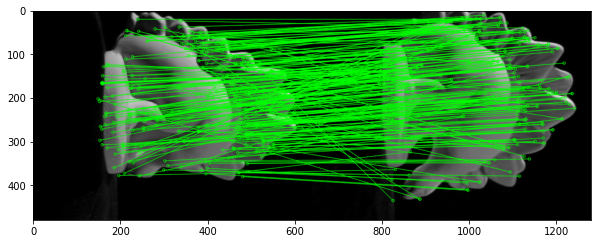

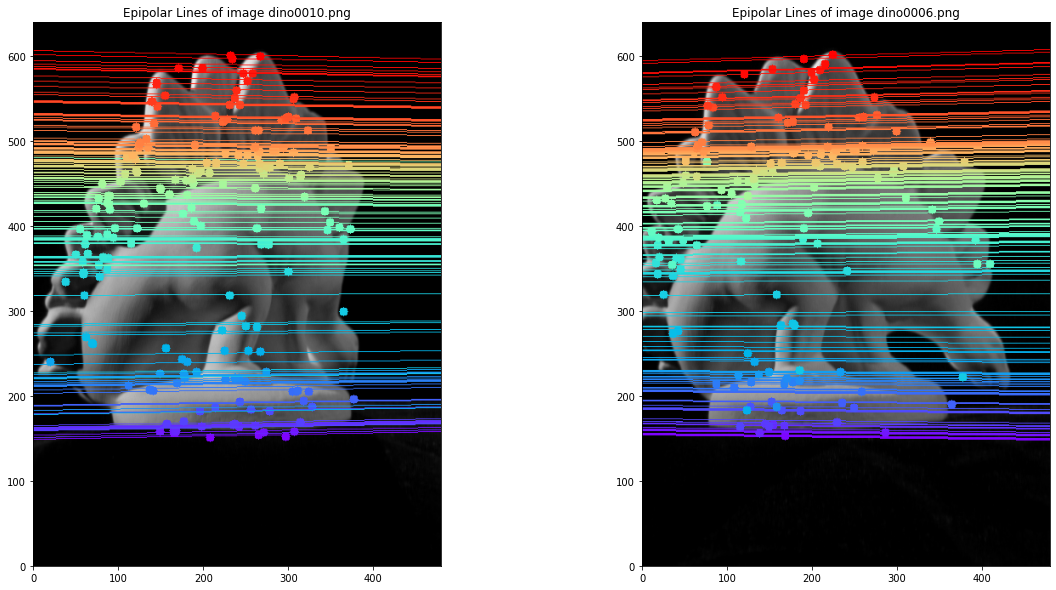

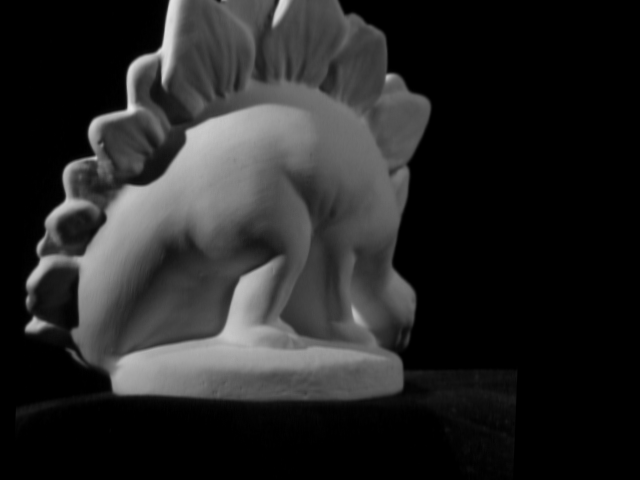

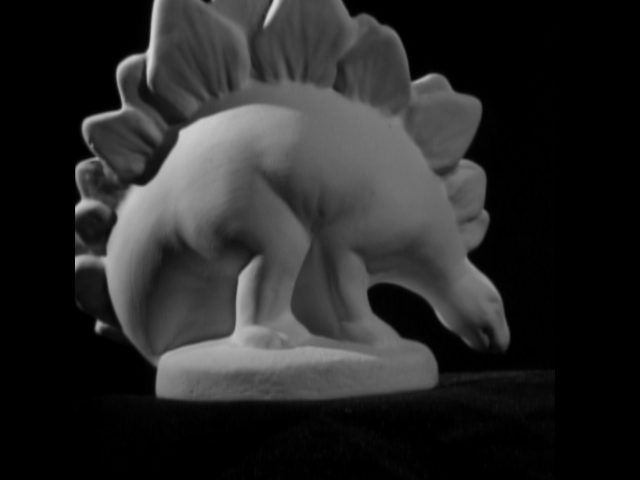

Sanity Check
Ensure the following matrices are equal [H1.T @ Fbar @ H0 = F]
[[ 4.28898578e-08  6.74581666e-06 -8.52260837e-02]
 [ 7.04666974e-06 -4.27598997e-08 -2.04282610e-03]
 [ 8.21582891e-02 -2.46327412e-03  1.00000000e+00]]
[[ 4.28898578e-08  6.74581666e-06 -8.52260837e-02]
 [ 7.04666974e-06 -4.27598997e-08 -2.04282610e-03]
 [ 8.21582891e-02 -2.46327412e-03  1.00000000e+00]]
Normalized sum of error based on epipolar constraint: 5859.2309710429045


<Figure size 432x288 with 0 Axes>

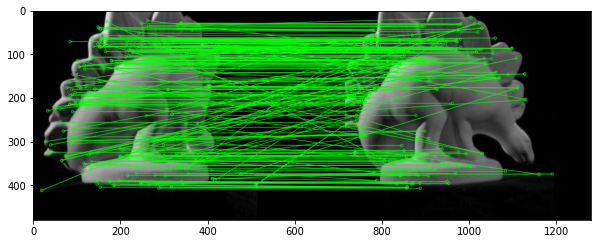

In [24]:
# Runs the script
run(image_index_0=10, image_index_1=6, calibration_filepath='dino_par.txt', match_method='SURF', threshold=0.9, outlier_bound=1, do_rectify=True, F_method='Direct', suppress_images=False)